In [1]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

sns.set_theme(context="talk", style="whitegrid", palette="colorblind")

# Stats

In [2]:
stats = pd.read_csv(
    "data/shome2023notebook/stats.csv",
    header=None,
    names=["notebook", "num_code_cells", "num_md_cells", "num_assert_cells"],
)
stats.head()

,notebook,num_code_cells,num_md_cells,num_assert_cells
0,data/assert_notebooks/0Zyablik0/Reinforcement-...,30,16,7
1,data/assert_notebooks/000Justin000/agnav/CS674...,10,0,1
2,data/assert_notebooks/01joy/stanford-cs224n-wi...,24,36,4
3,data/assert_notebooks/0xproflupin/bcd/Evaluati...,33,6,2
4,data/assert_notebooks/0xproflupin/bcd/Evaluati...,25,7,4


In [3]:
assert not stats.duplicated(subset=["notebook"]).all()

## How many notebooks with vs. without "assert" keyword

Unfortunately I did not collect the number of code cells in notebooks **without** "assert" keyword. But we can still show that very few notebooks have the "assert" keyword.

In [5]:
!grep '^INPUT' logs/data-collection-asserts.log |wc -l

302834


In [6]:
stats.shape

(29538, 4)

We had ~3M notebooks but only ~30K (~9.7%) notebooks contained the "assert" keyword.

# Asserts

In [10]:
asserts = pd.read_csv(
    "data/shome2023notebook/asserts.csv",
    header=None,
    names=["cell_type", "source", "notebook", "above", "below"],
    usecols=lambda x: x in ["notebook", "source"]
)
asserts.shape

(54932, 2)

In [12]:
# collect all tests (any python statement where "assert" keyword appears)
# then we can do some general exploration to see that python asserts are the most popular form of writing tests (thats why we focus here)

def get_ast(source: str) -> ast.Module:
    try:
        tree = ast.parse(source)
    except:
        tree = None
    finally:
        return tree

asserts.loc[:, "ast"] = asserts["source"].apply(get_ast)
asserts = asserts.loc[asserts["ast"].notna()]
asserts = asserts.loc[
    asserts["ast"].map(lambda x: True if list(ast.walk(x)) else False)
]
asserts.shape

<unknown>:13: SyntaxWarning: invalid escape sequence '\P'
<unknown>:13: SyntaxWarning: invalid escape sequence '\P'
<unknown>:13: SyntaxWarning: invalid escape sequence '\P'
<unknown>:71: SyntaxWarning: invalid escape sequence '\o'
<unknown>:2: SyntaxWarning: invalid escape sequence '\,'
<unknown>:16: SyntaxWarning: invalid escape sequence '\,'
<unknown>:58: SyntaxWarning: invalid escape sequence '\d'
<unknown>:58: SyntaxWarning: invalid escape sequence '\d'
<unknown>:2: SyntaxWarning: invalid escape sequence '\,'
<unknown>:16: SyntaxWarning: invalid escape sequence '\,'
<unknown>:58: SyntaxWarning: invalid escape sequence '\d'
<unknown>:58: SyntaxWarning: invalid escape sequence '\d'
<unknown>:176: SyntaxWarning: invalid escape sequence '\m'
<unknown>:185: SyntaxWarning: invalid escape sequence '\m'
<unknown>:23: SyntaxWarning: invalid escape sequence '\-'
<unknown>:13: SyntaxWarning: invalid escape sequence '\P'
<unknown>:12: SyntaxWarning: invalid escape sequence '\h'
<unknown>:13: 

(52238, 3)

In [23]:
class FunctionNameCollector(ast.NodeVisitor):
    def __init__(self):
        self.names = []

    def visit_Name(self, node: ast.Name) -> None:
        self.names.append(node.id)

    def visit_Attribute(self, node: ast.Attribute) -> None:
        self.names.append(node.attr)

collector = FunctionNameCollector()
call_nodes = asserts["ast"].apply(
    lambda x: [node for node in ast.walk(x) if isinstance(node, ast.Call)]
).explode().dropna()

for _, node in call_nodes.items():
    collector.visit(node.func)

names = pd.DataFrame(data=collector.names, columns=["function"])

In [24]:
names.loc[names["function"].str.contains("assert")]

,function
1911,assert_equal
1945,assert_existing_objects_matched
2752,assert_allclose
3072,assert_almost_equal
3073,assert_almost_equal
...,...
966120,assert_array_almost_equal
968224,assert_equal
971483,assert_array_almost_equal
972467,assert_array_less


In [26]:
class AssertCollector(ast.NodeVisitor):
    def __init__(self):
        self.nodes = []

    def visit_Assert(self, node: ast.Assert) -> None:
        self.nodes.append(node)

def get_assert_nodes(tree: ast.Module) -> list[ast.Assert]:
    collector = AssertCollector()
    collector.visit(tree)
    return collector.nodes

asserts.loc[:, "assert"] = asserts.loc[:, "ast"].apply(get_assert_nodes)
asserts = asserts.explode("assert")
asserts = asserts.loc[asserts["assert"].notna()]

In [27]:
asserts.shape

(92420, 4)

~5% of the tests we discover are not `assert` statements but calls to external testing libraries.

In [158]:
vectorizer = CountVectorizer(
    stop_words=["assert"],
)
X = vectorizer.fit_transform(asserts["assert"])
counts = pd.DataFrame(
    data={"count": X.toarray().sum(axis=0)},
    index=vectorizer.get_feature_names_out(),
)
counts = counts.sort_values(by=["count"], ascending=False)

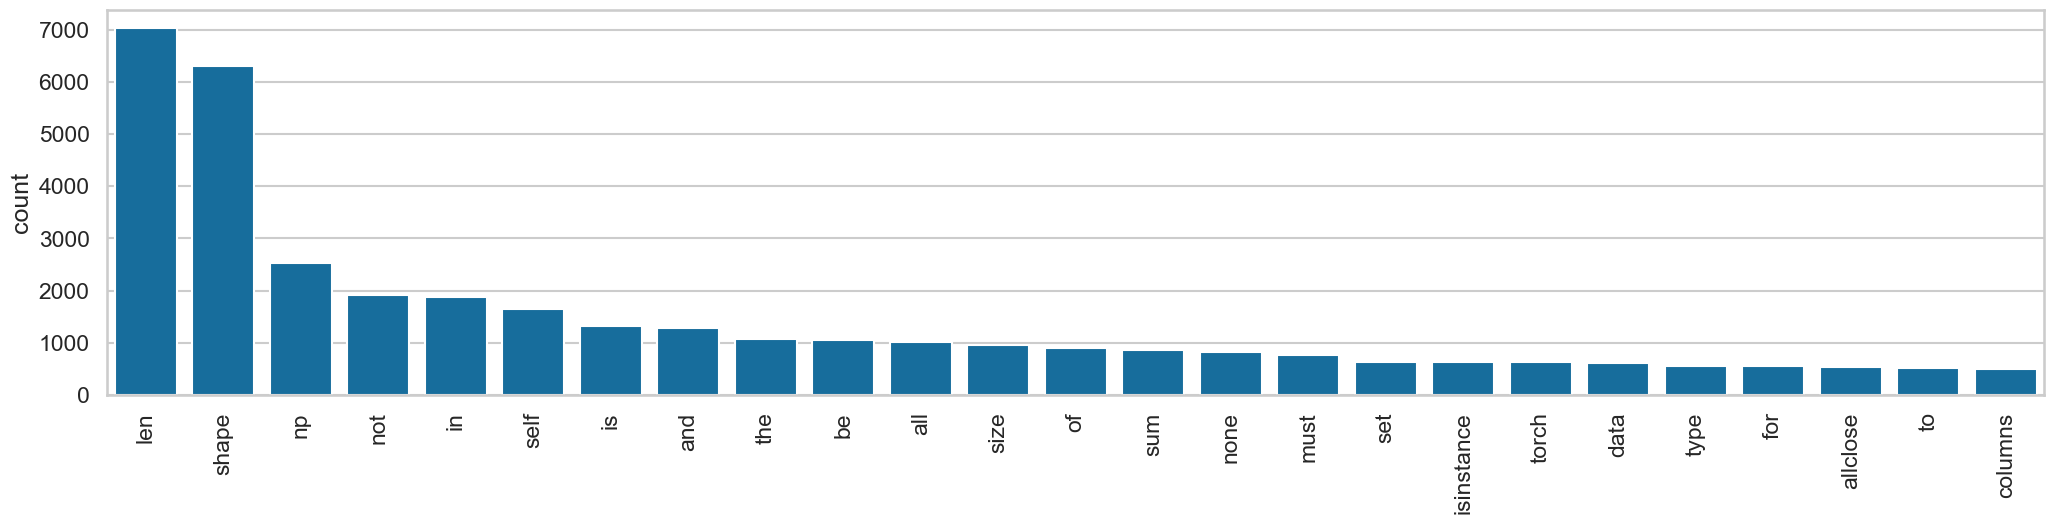

In [159]:
fig, ax = plt.subplots(figsize=(25,5))
sns.barplot(
    data=counts["count"].head(25),
    ax=ax,
)
ax.tick_params(axis='x', rotation=90)

In [160]:
vectorizer = TfidfVectorizer(
    stop_words=["assert"],
)
X = vectorizer.fit_transform(asserts["assert"])
occurances = pd.DataFrame(
    data={"freq": X.toarray().max(axis=0)},
    index=vectorizer.get_feature_names_out(),
)
occurances = occurances.sort_values(by=["freq"], ascending=False)

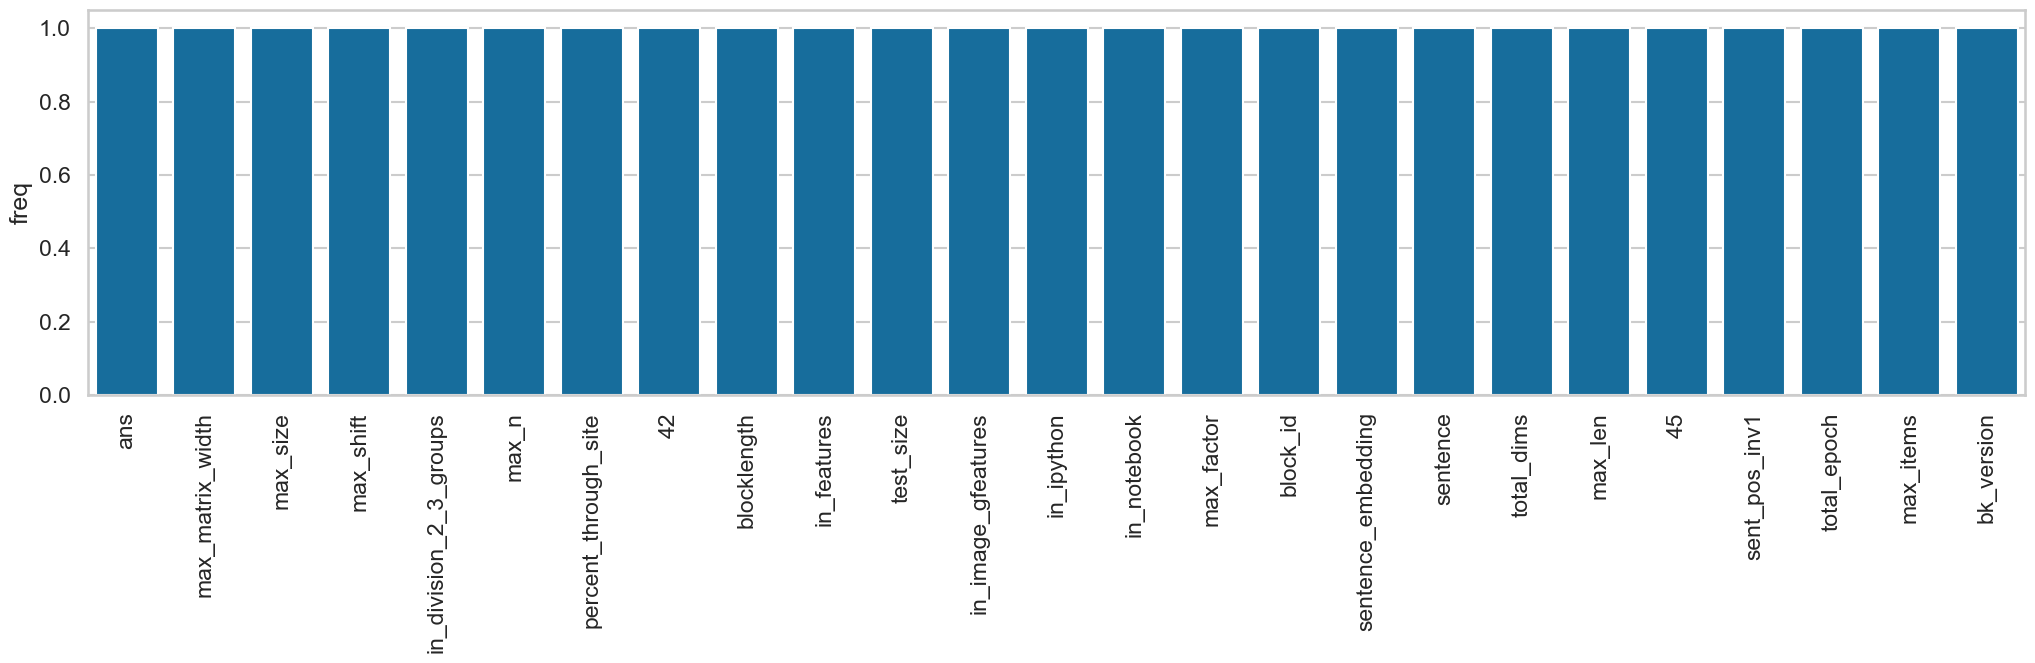

In [161]:
fig, ax = plt.subplots(figsize=(25,5))
sns.barplot(
    data=occurances["freq"].head(25),
    ax=ax,
)
ax.tick_params(axis='x', rotation=90)

In [162]:
occurances.head(10)

,freq
ans,1.0
max_matrix_width,1.0
max_size,1.0
max_shift,1.0
in_division_2_3_groups,1.0
max_n,1.0
percent_through_site,1.0
42,1.0
blocklength,1.0
in_features,1.0


In [163]:
occurances.describe()

,freq
count,18959.000000
mean,0.600076
std,0.199716
min,0.022150
25%,0.448962
50%,0.607555
75%,0.722547
max,1.000000


In [164]:
asserts.loc[:, "tokens"] = asserts.loc[:, "assert"].apply(vectorizer.build_analyzer())
asserts.loc[:, "sum_freq"] = X.toarray().sum(axis=1) # sum all columns to get TF-IDF of all tokens in each asser
asserts.loc[:, "max_freq"] = X.toarray().max(axis=1) # luis: take max TF-IDF of all tokens in assert
asserts = asserts.loc[asserts["tokens"].map(lambda x: True if x else False)] # remove asserts without any tokens

/var/folders/3_/dh2k952n2rld3_w3r369mln80000gn/T/ipykernel_41636/11873473.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  asserts.loc[:, "tokens"] = asserts.loc[:, "assert"].apply(vectorizer.build_analyzer())
/var/folders/3_/dh2k952n2rld3_w3r369mln80000gn/T/ipykernel_41636/11873473.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  asserts.loc[:, "sum_freq"] = X.toarray().sum(axis=1) # sum all columns to get TF-IDF of all tokens in each asser
/var/folders/3_/dh2k952n2rld3_w3r369mln80000gn/T/ipykernel_4

In [165]:
asserts.sort_values(by=["sum_freq"], ascending=False)

,notebook,assert,source,tokens,sum_freq,max_freq
24,data/quaranta2021kgtorrent/KT_dataset/rox1234_...,"assert sorted(bow)[::200] == ['!', '12500', '2...","assert sorted(bow)[::200] == ['!', '12500', '2...","[sorted, bow, 200, 12500, 270, 700, by, gh, mi...",7.124642,0.142553
26,data/quaranta2021kgtorrent/KT_dataset/alishera...,"assert sorted(bow_vocabulary)[::200] == ['!', ...","assert sorted(bow_vocabulary)[::200] == ['!', ...","[sorted, bow_vocabulary, 200, 12500, 270, 700,...",7.124430,0.148240
37,data/assert_notebooks/kudojp/IBMRecommendation...,"assert set(get_article_names([1024, 1176, 1305...",# Test your functions here - No need to change...,"[set, get_article_names, 1024, 1176, 1305, 131...",6.953021,0.257335
35,data/assert_notebooks/AhmadGilangArinanda/Udac...,"assert set(get_article_names(['1024.0', '1176....",# Test your functions here - No need to change...,"[set, get_article_names, 1024, 1176, 1305, 131...",6.953021,0.257335
18,data/assert_notebooks/jadei2508/task5/hw_class...,"assert np.allclose(lr_clf.weights_, np.array([...","assert np.allclose(lr_clf.weights_, np.array([...","[np, allclose, lr_clf, weights_, np, array, 1e...",6.349455,0.657790
...,...,...,...,...,...,...
2,data/assert_notebooks/ChrisCummins/phd/docs/wi...,assert telemetries,"def ReadTelemetryFiles(outdir: pathlib.Path, g...",[telemetries],1.000000,1.000000
64,data/assert_notebooks/157239n/k1lib/k1lib/cli/...,"assert a | indexTable(1) == {3: [[0, 3, 0.1], ...","a = [[0, 3, 0.1], [0, 4, 0.2], [1, 3, 0.3], [1...",[indextable],1.000000,1.000000
33,data/assert_notebooks/chengsoonong/digbeta/dch...,assert C1 > 0,"def obj_hybrid_TP_LR(w, X, Y, C, C1, r=8, weig...",[c1],1.000000,1.000000
37,data/assert_notebooks/mhagiwara/one-month-chal...,assert v == v1,"with tf.variable_scope(""foo""):\n v = tf.get...",[v1],1.000000,1.000000


In [100]:
asserts.sort_values(by=["max_freq"], ascending=False)

,notebook,assert,source,tokens,sum_freq,max_freq
11,data/assert_notebooks/kaschbacher/publications...,assert freq_vec[0] != 0,# This function calculates the power spectrum ...,[freq_vec],1.000000,1.000000
12,data/assert_notebooks/benediktwagner/ml-reaser...,assert 0 <= initial_value <= 1,def Or(*wffs):\n if len(wffs) == 0:\n ...,[initial_value],1.000000,1.000000
3,data/assert_notebooks/nikohou/LoadLanguageMode...,assert dim % 2 == 0,\n# constants\nModelPrediction = namedtuple('...,[dim],1.000000,1.000000
13,data/assert_notebooks/CarsonStevens/Mines-Cour...,assert coefs,"assert coefs\nassert coefs[0].shape == (10,)\n...",[coefs],1.000000,1.000000
3,data/assert_notebooks/choderalab/coddiwomple/t...,assert hl_size[0] == 2,"def polynomial_potential(x, hl):\n """"""\n ...",[hl_size],1.000000,1.000000
...,...,...,...,...,...,...
34,data/assert_notebooks/charchit7/Deep-Learning-...,"assert np.allclose(encoderq_output.numpy(), [[...",# UNIT TEST\ndef Encoder_test(target):\n tf...,"[np, allclose, encoderq_output, numpy, 0606649...",5.338084,0.196771
32,data/assert_notebooks/Ankit-Kumar-Saini/Course...,"assert np.allclose(encoderq_output.numpy(), [[...",# UNIT TEST\ndef Encoder_test(target):\n tf...,"[np, allclose, encoderq_output, numpy, 4017230...",5.338084,0.196771
24,data/quaranta2021kgtorrent/KT_dataset/rox1234_...,"assert sorted(bow)[::200] == ['!', '12500', '2...","assert sorted(bow)[::200] == ['!', '12500', '2...","[sorted, bow, 200, 12500, 270, 700, by, gh, mi...",7.121774,0.142993
26,data/quaranta2021kgtorrent/KT_dataset/alishera...,"assert sorted(bow_vocabulary)[::200] == ['!', ...","assert sorted(bow_vocabulary)[::200] == ['!', ...","[sorted, bow_vocabulary, 200, 12500, 270, 700,...",7.122358,0.142875


In [166]:
asserts.loc[:, "bin"] = pd.qcut(asserts.loc[:, "sum_freq"], 4, labels=False)
asserts["bin"].value_counts()

bin
1    4914
0    4914
3    4913
2    4912
Name: count, dtype: int64

In [171]:
asserts.loc[asserts["bin"] == 3].sample(25)

,notebook,assert,source,tokens,sum_freq,max_freq,bin
9,data/assert_notebooks/trinhgiahuy/OpenKinTest/...,"assert noFeatures == 1, 'The number of input f...",gpu_devices = tf.config.experimental.list_phys...,"[nofeatures, the, number, of, input, features,...",3.141478,0.460073,3
11,data/assert_notebooks/KNSI-Golem/Bootcamp2021/...,"assert train_X.shape[1] == test_X.shape[1], 'N...",# categorical features - just remove them\ntra...,"[train_x, shape, test_x, shape, numbers, of, f...",3.349834,0.399363,3
13,data/assert_notebooks/KellerJordan/Congress-Da...,assert bool_coef.size + cat_coef.size + text_c...,"vec.inv_vocab = {k: w for w, k in vec.vocabula...","[bool_coef, size, cat_coef, size, text_coef, s...",2.354723,0.636278,3
4,data/assert_notebooks/bpRsh/Practice_problems/...,assert ip >= self._ip_lowbounds[index] and (in...,class IpLookupTable(object):\n def __init__...,"[ip, self, _ip_lowbounds, index, and, index, s...",2.374219,0.538175,3
131,data/assert_notebooks/PeeteKeesel/gnn-for-drug...,assert drug_name_fps_df.shape[0] == len(drmGDS...,drmGDSC2 = pd.read_pickle(PROCESSED_DATA_PATH ...,"[drug_name_fps_df, shape, len, drmgdsc2, drug_...",2.984599,0.516280,3
5,data/assert_notebooks/l5shi/Image-Recognition-...,"assert s == step_size, 'step_size must equal t...","def build_spatial_pyramid(image, descriptor, l...","[step_size, step_size, must, equal, to, dsift_...",2.438710,0.709850,3
20,data/quaranta2021kgtorrent/KT_dataset/gainknow...,"assert testImage.shape == (dfTmp.shape[0], 28,...",dfTmp = dfPredict.copy(deep=True) # make a cop...,"[testimage, shape, dftmp, shape, 28, 28, the, ...",2.900123,0.580358,3
12,data/assert_notebooks/tsumansapkota/Experiment...,"assert d0 * patch_size[0] == image_dim[-2], 'I...",class MlpMixer(nn.Module):\n \n def __in...,"[d0, patch_size, image_dim, image, must, be, d...",3.022995,0.443098,3
3,data/assert_notebooks/Hesamalian/BERT-Embeddin...,"assert 'COLAB_TPU_ADDR' in os.environ, 'ERROR:...","assert 'COLAB_TPU_ADDR' in os.environ, 'ERROR:...","[colab_tpu_addr, in, os, environ, error, not, ...",4.185979,0.317132,3
23,data/assert_notebooks/cartercompbio/EUGENe/not...,"assert isinstance(sdata.uns['pfms'][0], pd.Dat...","def test_generate_pfms_sdata(model, sdata):\n ...","[isinstance, sdata, uns, pfms, pd, dataframe]",2.387506,0.493570,3


In [140]:
for idx in asserts["bin"].unique():
    asserts.loc[asserts["bin"] == idx].sample(100, random_state=42).to_csv(f"data/shome2023notebook/quartile-{idx}.csv")

# Outputs

In [32]:
github = pd.read_csv(
    "data/shome2023notebook/kaggle-outputs.csv",
    header=None,
    names=["notebook", "source", "output_type", "text", "has_image", "has_html"],
    usecols=lambda x: x in ["notebook", "output_type"],
)
github

KeyboardInterrupt: 

# Print outputs

In [3]:
prints = pd.read_csv(
    "data/shome2023notebook/output-prints.csv",
    index_col=0,
)
prints

,notebook,print,text,source
38,data/assert_notebooks/declanvk/data301-project...,"print(accuracy_score(ytest, gaussian_ypredict))",0.742537313433\n,"print(accuracy_score(ytest, gaussian_ypredict))"
43,data/assert_notebooks/declanvk/data301-project...,"print(accuracy_score(ytest, youtput))",0.817164179104\n,youtput = rforest_model.predict(Xtest)\n\nprin...
47,data/assert_notebooks/declanvk/data301-project...,"print(val_scores.mean(), val_scores.std())",0.82386618999 0.0445362753371\n,"print(val_scores.mean(), val_scores.std())"
2,data/assert_notebooks/0lidaxiang/dp-predict-st...,"print('Rows of dataset=%d, training set rows=%...","Rows of dataset=946, training set rows=757, te...",# Read pickle and split training and testing s...
5,data/assert_notebooks/0lidaxiang/dp-predict-st...,"print(X_train.shape, Y_train.shape)","(757, 20) (757,)\n",# Create training inputs\n# print(type(train_d...
...,...,...,...,...
16,data/quaranta2021kgtorrent/KT_dataset/vladzern...,print(any(data_test['Fare'].isnull())),False\nFalse\nTrue\nFalse\nFalse\nTrue\nFalse\n,print(any(data_test['Pclass'].isnull()))\nprin...
16,data/quaranta2021kgtorrent/KT_dataset/vladzern...,print(any(data_test['Embarked'].isnull())),False\nFalse\nTrue\nFalse\nFalse\nTrue\nFalse\n,print(any(data_test['Pclass'].isnull()))\nprin...
20,data/quaranta2021kgtorrent/KT_dataset/vladzern...,"print(metrics.classification_report(ypred, yte...",precision recall f1-score ...,ypred = model.predict(Xtest)\nfrom sklearn imp...
30,data/quaranta2021kgtorrent/KT_dataset/gauravdu...,print(text_representation),|--- feature_0 <= 54.50\n| |--- feature_1 <=...,\nfrom sklearn import tree\ntext_representatio...


In [4]:
vectorizer = CountVectorizer(
    stop_words=["print"],
)
X = vectorizer.fit_transform(prints["print"])
counts = pd.DataFrame(
    data={"count": X.toarray().sum(axis=0)},
    index=vectorizer.get_feature_names_out(),
)
counts = counts.sort_values(by=["count"], ascending=False)

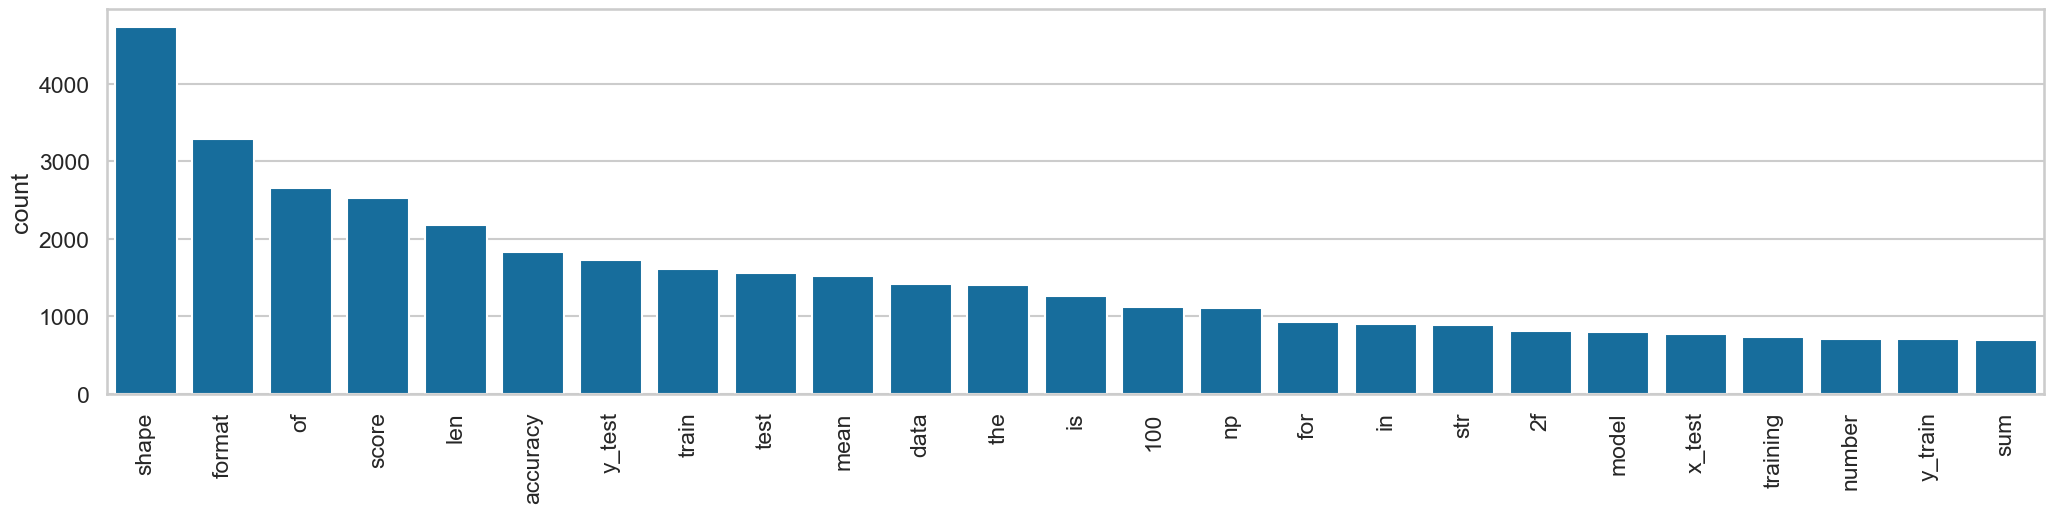

In [5]:
fig, ax = plt.subplots(figsize=(25,5))
sns.barplot(
    data=counts["count"].head(25),
    ax=ax,
)
ax.tick_params(axis='x', rotation=90)

In [6]:
vectorizer = TfidfVectorizer(
    stop_words=["print"],
)
X = vectorizer.fit_transform(prints["print"])
occurances = pd.DataFrame(
    data={"freq": X.toarray().max(axis=0)},
    index=vectorizer.get_feature_names_out(),
)
occurances = occurances.sort_values(by=["freq"], ascending=False)

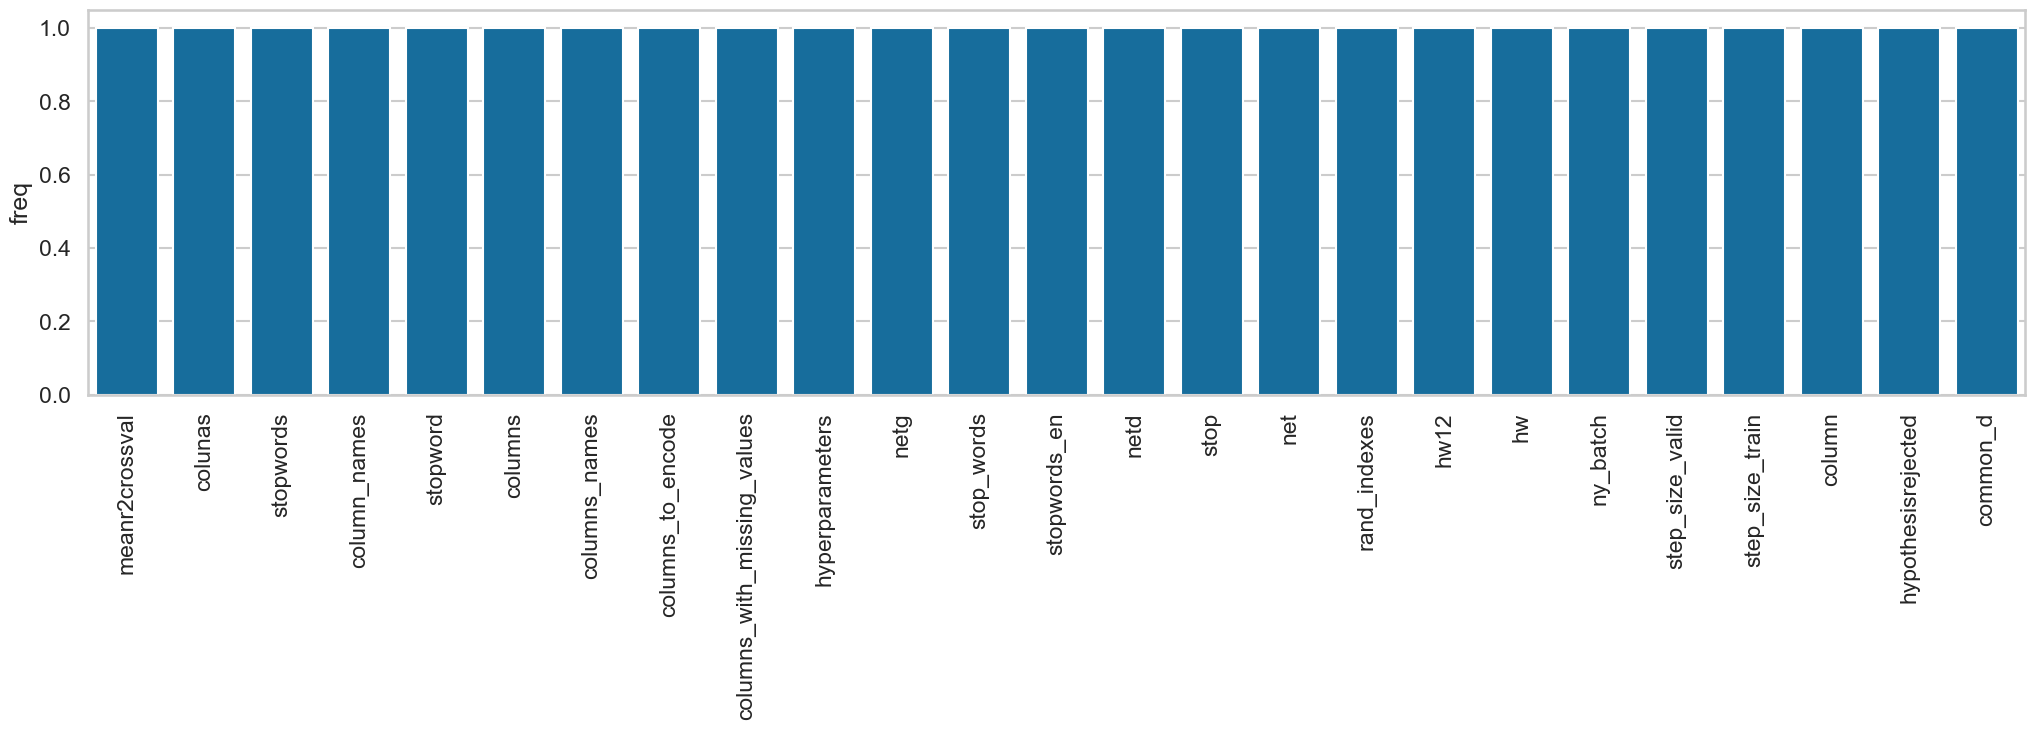

In [7]:
fig, ax = plt.subplots(figsize=(25,5))
sns.barplot(
    data=occurances["freq"].head(25),
    ax=ax,
)
ax.tick_params(axis='x', rotation=90)

In [8]:
prints.loc[:, "tokens"] = prints.loc[:, "print"].apply(vectorizer.build_analyzer())
prints.loc[:, "sum_freq"] = X.toarray().sum(axis=1) # sum all columns to get TF-IDF of all tokens in each asser
prints.loc[:, "max_freq"] = X.toarray().max(axis=1) # luis: take max TF-IDF of all tokens in assert
prints = prints.loc[prints["tokens"].map(lambda x: True if x else False)] # remove asserts without any tokens

In [10]:
prints.loc[:, "bin"] = pd.qcut(prints["sum_freq"], 4, labels=False)
prints["bin"].value_counts()

/var/folders/3_/dh2k952n2rld3_w3r369mln80000gn/T/ipykernel_36562/2468383750.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prints.loc[:, "bin"] = pd.qcut(prints["sum_freq"], 4, labels=False)


bin
0    6254
3    6254
1    6253
2    6253
Name: count, dtype: int64

In [11]:
for idx in prints["bin"].unique():
    prints.loc[prints["bin"] == idx].sample(100, random_state=42).to_csv(f"data/shome2023notebook/prints-quartile-{idx}.csv")

In [6]:
import pandas as pd
files = !find data/shome2023notebook -type f -name 'prints-quartile-*.csv' -or -name 'texts-quartile-*.csv'
frames = []
for file in files:
    frames.append(pd.read_csv(file, index_col=0, usecols=["notebook"]))
notebooks = pd.concat(frames)
notebooks.to_csv("data/shome2023notebook/output-notebooks.txt", sep="\t", header=None)

# Text outputs

In [19]:
texts = pd.read_csv(
    "data/shome2023notebook/output-texts.csv",
    index_col=0,
).dropna()
texts

,notebook,last_node,text,source
6,data/assert_notebooks/declanvk/data301-project...,raw_data.head(),survived pclass sex age sibsp parc...,raw_data.head()
21,data/assert_notebooks/declanvk/data301-project...,X.head(),pclass age sibsp parch fare alone ...,X.head()
41,data/assert_notebooks/declanvk/data301-project...,"rforest_model.fit(Xtrain, ytrain)","RandomForestClassifier(bootstrap=True, class_w...",from sklearn.ensemble import RandomForestClass...
49,data/assert_notebooks/declanvk/data301-project...,plt.ylabel('predicted label'),<matplotlib.figure.Figure at 0x7f4cae8878d0>,from sklearn.metrics import confusion_matrix\n...
51,data/assert_notebooks/declanvk/data301-project...,"feature_importance.sort_values('importance', a...",feature importance\n7 male ...,feature_importance = pd.DataFrame({'feature': ...
...,...,...,...,...
38,data/quaranta2021kgtorrent/KT_dataset/gauravdu...,"confusion_matrix(y_train, y_train_pred)","array([[69, 18],\n [26, 49]])","print(accuracy_score(y_train, y_train_pred))\n..."
23,data/quaranta2021kgtorrent/KT_dataset/nataliam...,"c_w_train = dict(zip(range(4), c_w))",<Figure size 576x576 with 1 Axes>,c_w = get_class_weights(y_train)\nplot_class_w...
24,data/quaranta2021kgtorrent/KT_dataset/nataliam...,"plot_class_weights(get_class_weights(y_val), t...",<Figure size 576x576 with 1 Axes>,"plot_class_weights(get_class_weights(y_val),ti..."
31,data/quaranta2021kgtorrent/KT_dataset/nataliam...,vizualize_history(hist),<Figure size 576x576 with 1 Axes>,vizualize_history(hist)


In [21]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(texts["last_node"])
counts = pd.DataFrame(
    data={"count": X.toarray().sum(axis=0)},
    index=vectorizer.get_feature_names_out(),
)
counts = counts.sort_values(by=["count"], ascending=False)

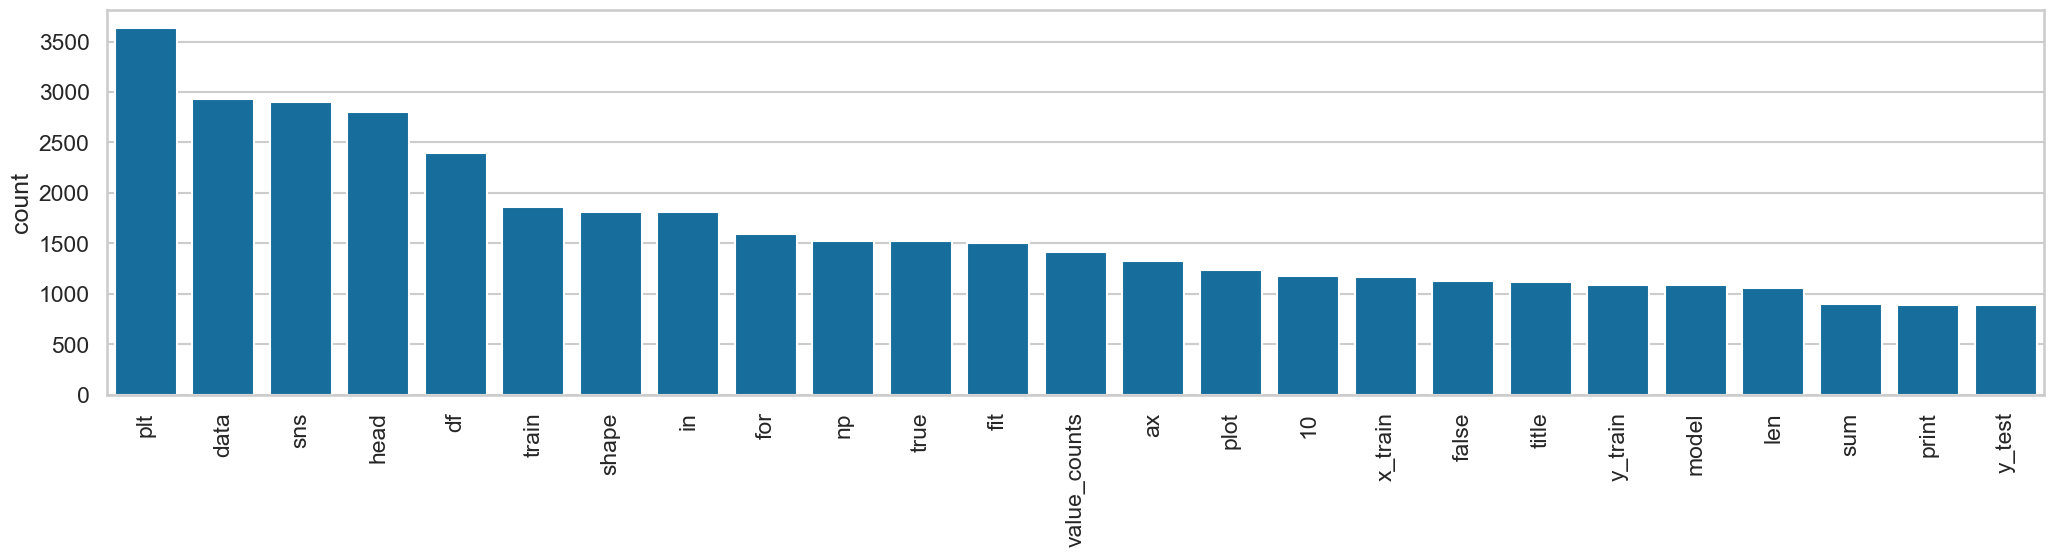

In [22]:
fig, ax = plt.subplots(figsize=(25,5))
sns.barplot(
    data=counts["count"].head(25),
    ax=ax,
)
ax.tick_params(axis='x', rotation=90)

In [23]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(texts["last_node"])
occurances = pd.DataFrame(
    data={"freq": X.toarray().max(axis=0)},
    index=vectorizer.get_feature_names_out(),
)
occurances = occurances.sort_values(by=["freq"], ascending=False)

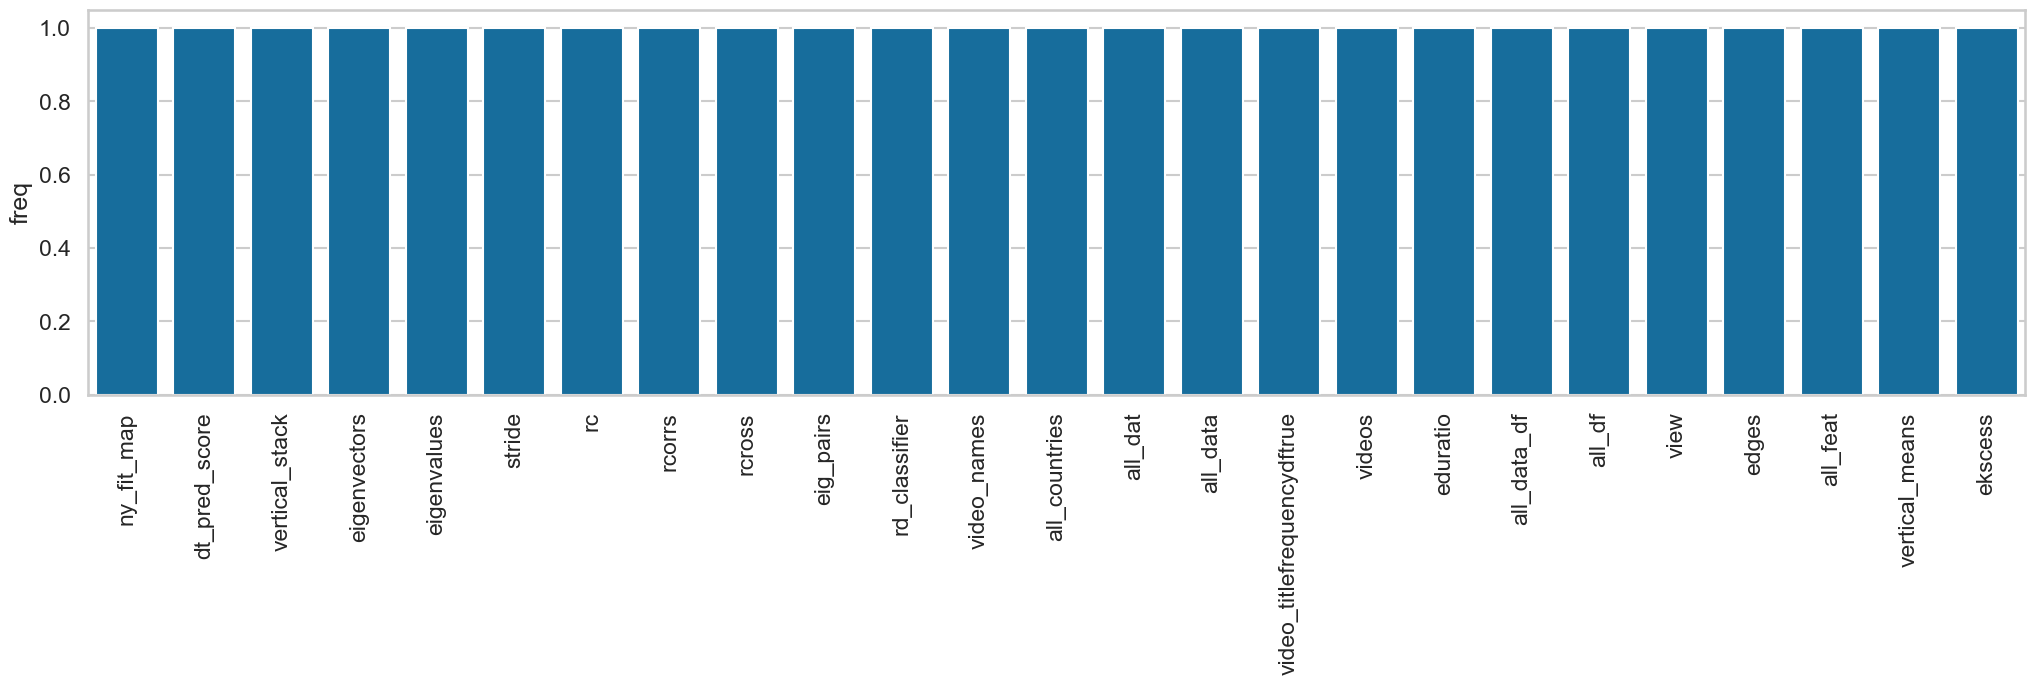

In [24]:
fig, ax = plt.subplots(figsize=(25,5))
sns.barplot(
    data=occurances["freq"].head(25),
    ax=ax,
)
ax.tick_params(axis='x', rotation=90)

In [26]:
texts.loc[:, "tokens"] = texts.loc[:, "last_node"].apply(vectorizer.build_analyzer())
texts.loc[:, "sum_freq"] = X.toarray().sum(axis=1) # sum all columns to get TF-IDF of all tokens in each asser
texts.loc[:, "max_freq"] = X.toarray().max(axis=1) # luis: take max TF-IDF of all tokens in assert
texts = texts.loc[texts["tokens"].map(lambda x: True if x else False)] # remove asserts without any tokens

In [27]:
texts.loc[:, "bin"] = pd.qcut(texts["sum_freq"], 4, labels=False)
texts["bin"].value_counts()

/var/folders/3_/dh2k952n2rld3_w3r369mln80000gn/T/ipykernel_36562/3414631874.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  texts.loc[:, "bin"] = pd.qcut(texts["sum_freq"], 4, labels=False)


bin
0    7112
3    7109
2    7108
1    7106
Name: count, dtype: int64

In [28]:
for idx in texts["bin"].unique():
    texts.loc[texts["bin"] == idx].sample(100, random_state=42).to_csv(f"data/shome2023notebook/texts-quartile-{idx}.csv")